## Imports

In [25]:
from pathlib import Path

import re

from fractions import Fraction
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.stats import entropy
from scipy.optimize import minimize
import cvxpy as cp
import pymc3 as pm

In [2]:
DATA_PATH = Path("../data")

## DIY sampler

### One approach

Here we fix alpha and beta and use a separately generated probability.

In [44]:
# Data
y_obs = stats.bernoulli(p=0.7).rvs(100)

In [43]:
# Function to calculate pointwise posterior
def calc_post(data, prob, alpha, beta):
    if 0 <= prob <= 1:
        prior = stats.beta(a=alpha, b=beta).pdf(prob)
        likel = stats.bernoulli(p=prob).pmf(data).prod()
        post = prior * likel
    else: 
        post = -np.inf
    return post

In [46]:
# Implement algorithm
# Fixed parameters
n_samples = 10000
alpha = beta = 1  # Beta is equivalent to uniform distribution
sd = 0.05 # This determines the size of the sampling step

# Initial sampling parameters
prob_now = 0.5
trace_1 = {"prob": np.zeros(n_samples)}
post_now = calc_post(y_obs, prob_init, alpha, beta)

# sample posterior
for i in range(n_samples):
    prob_new = stats.norm(loc=prob_now, scale=sd).rvs(1) # propose new probability value with a step from previous one
    post_new = calc_post(y_obs, prob_new, alpha, beta)
    prob_acc = post_new/post_now
    if prob_acc > stats.uniform(loc=0, scale=1).rvs(1):
        prob_now = prob_new
        post_now = post_new
    trace_1["prob"][i] = prob_now

### Other approach

Here we define the problem in terms of priors for alpha and beta

In [59]:
def calc_post_2(data, alpha, beta):
    if (alpha > 0) & (beta > 0):
        prob = stats.beta(a=alpha, b=beta).rvs(1)
        prior = stats.beta(a=alpha, b=beta).pdf(prob)
        likel = stats.bernoulli(p=prob).pmf(data).prod()
        post = prior * likel
    else:
        post = -np.inf
    return post

In [70]:
# Fixed parameter
n_samples = 100000
proposal_jump_size = 1000

# Start parameter
alpha_now = 1
beta_now = 1
trace_2 = {
    "alpha": np.zeros(n_samples),
    "beta": np.zeros(n_samples)
}
post_now = calc_post_2(y_obs, alpha_now, beta_now)

for i in range(n_samples):
    alpha_new = stats.norm(alpha_now, proposal_jump_size).rvs(1)
    beta_new = stats.norm(beta_now, proposal_jump_size).rvs(1)
    post_new = calc_post_2(y_obs, alpha_new, beta_new)
    prob_acc = post_new/post_now
    
    if prob_acc > stats.uniform(0, 1).rvs(1):
        alpha_now = alpha_new
        beta_now = beta_new
        post_now = post_new
        
    trace_2["alpha"][i] = alpha_now
    trace_2["beta"][i] = beta_now

### Figures

(array([2.66731409e-03, 2.66731409e-03, 2.13385127e-02, 9.86906213e-02,
        5.46799388e-01, 2.77133934e+00, 7.31110792e+00, 9.99175858e+00,
        5.21993367e+00, 7.06838234e-01]),
 array([0.54307353, 0.58056443, 0.61805533, 0.65554623, 0.69303712,
        0.73052802, 0.76801892, 0.80550982, 0.84300072, 0.88049161,
        0.91798251]),
 <BarContainer object of 10 artists>)

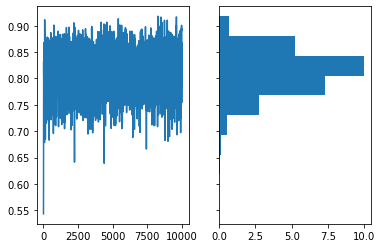

In [47]:
fig, axes = plt.subplots(len(trace_1), 2, sharey=True)
axes[0].plot(trace_1[key],
               color="C0",
               linestyle="-",
               marker=""
              )
axes[1].hist(trace_1[key],
                color="C0",
                orientation="horizontal",
                density=True
               )

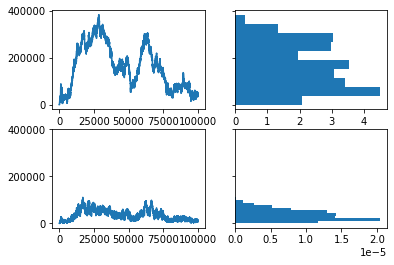

In [73]:
fig, axes = plt.subplots(len(trace_2), 2, sharey=True)
for i, key in enumerate(trace_2.keys()):
    axes[i, 0].plot(trace_2[key],
                   color="C0",
                   linestyle="-",
                   marker=""
                  )
    axes[i, 1].hist(trace_2[key],
                    color="C0",
                    orientation="horizontal",
                    density=True
                   )

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

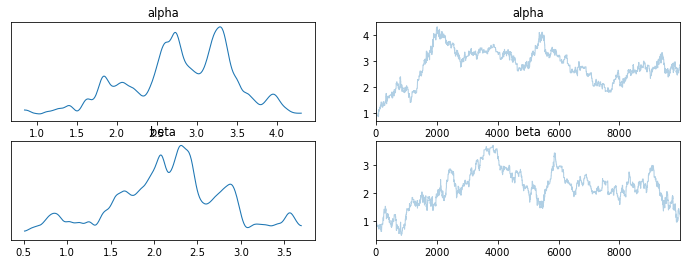

In [27]:
az.plot_trace(data=trace, var_names=["alpha", "beta"])

In [30]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,4.21,2.57,1.21,9.33
beta,1.61,0.67,0.57,3.12


## Maximum entropy priors

In [67]:
constraints = [
    [
        {"type": "eq", "fun": lambda x: np.sum(x) - 1}
    ],
    [
        {"type": "eq", "fun": lambda x: np.sum(x) - 1},
        {"type": "eq", "fun": lambda x: 1.5 - (x @ np.arange(1, 7))}
    ],
    [
        {"type": "eq", "fun": lambda x: np.sum(x) - 1},
        {"type": "eq", "fun": lambda x: np.sum(x[[2, 3]]) - 0.8}
    ]
]

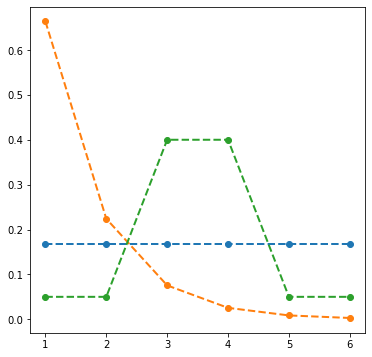

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))
x_array = np.arange(1, 7)
max_ent = []
for i, cons in enumerate(constraints):
    fit = minimize(lambda x: -entropy(x),
                   x0=[1/6] * 6,
                   constraints=cons,
                   bounds=[(0., 1.)] * 6, 
                   options={"maxiter": 500}
                  )
    x_freq = fit["x"]
    max_ent.append(entropy(x_freq))
    ax.plot(x_array, 
            x_freq, 
            "o--",
            color=f"C{i}",
            lw=2)

In [69]:
fit

     fun: -1.332179040209978
     jac: array([-1.66355374, -1.66355376,  0.41588825,  0.41588838, -1.66355376,
       -1.663551  ])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.04999997, 0.04999997, 0.39999997, 0.40000003, 0.04999997,
       0.0500001 ])

### Test other random distributions

In [88]:
n_samples = 100_000
entropies = np.zeros(shape=(3, n_samples))
for i in range(n_samples):
    tot = 0
    x_freq = np.zeros(len(x_array))
    x_ = np.random.choice(x_array, size=6, replace=False)
    for x_i in x_[:-1]:
        x_i_prob = np.random.uniform(0, 1-tot)
        x_freq[x_i-1] = x_i_prob
        tot += x_i_prob
    x_freq[x_[-1]-1] = 1 - tot
    H = entropy(x_freq)
    entropies[0, i] = H
    if abs(1.5 - np.sum(x_freq * x_)) < 0.01:
        entropies[1, i] = H
    prob_34 = np.sum(x_freq[np.argwhere((x_ == 3) | (x_ == 4)).ravel()])
    if abs(0.8 - prob_34) < 0.01:
        entropies[2, i] = H

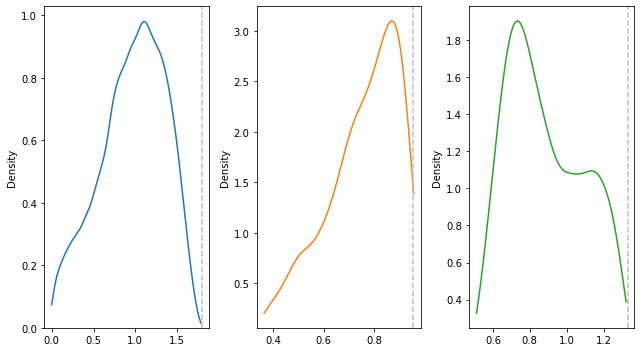

In [89]:
fig, axes = plt.subplots(1, entropies.shape[0], figsize=(9, 5))
axes = axes.ravel()
for i in range(entropies.shape[0]):
    to_plot = np.ma.array(entropies[i, :], mask=(entropies[i, :] == 0))
    sns.kdeplot(
        ax=axes[i],
        x=to_plot,
        color=f"C{i}",
        clip=[to_plot.min(), to_plot.max()]
    )
    axes[i].axvline(x=max_ent[i],
                    linestyle="--",
                    color="silver"
                   )              
plt.tight_layout()

## Random - test optimization methods

In [312]:
nutrients = ["calories", "protein_g", "calcium_g", "iron_mg", "vitamin_a_iu", 
             "vitamin_b1_mg", "vitamin_b2_mg", "niacin_mg", "vitamin_c_mg"]
required_levels = [2000, 70, 0.8, 12, 5, 1.8, 2.7, 18, 75]

In [315]:
df_stig = pd.read_csv(DATA_PATH / "stigler.csv")

In [316]:
df_stig.head()

,commodity,unit,price_cents,calories,protein_g,calcium_g,iron_mg,vitamin_a_iu,vitamin_b1_mg,vitamin_b2_mg,niacin_mg,vitamin_c_mg
0,Wheat Flour (Enriched),10 lb.,36.0,44.7,1411,2.0,365,0.0,55.4,33.3,441,0
1,Macaroni,1 lb.,14.1,11.6,418,0.7,54,0.0,3.2,1.9,68,0
2,Wheat Cereal (Enriched),28 oz.,24.2,11.8,377,14.4,175,0.0,14.4,8.8,114,0
3,Corn Flakes,8 oz.,7.1,11.4,252,0.1,56,0.0,13.5,2.3,68,0
4,Corn Meal,1 lb.,4.6,36.0,897,1.7,99,30.9,17.4,7.9,106,0


In [317]:
def get_unit_type(unit):
    unit_type = unit.split(" ")[1]
    return unit_type

def get_unit_value(unit):
    unit_val = float(unit.split(" ")[0])
    return unit_val

In [318]:
df_stig = (df_stig
           .assign(
               unit_val=lambda x:x["unit"].apply(get_unit_value),
               unit_type=lambda x:x["unit"].apply(get_unit_type)
           )
           .drop(
               ["unit"],
               axis=1
           )
          )

In [319]:
df_stig[nutrients] = df_stig[nutrients] / df_stig["unit_val"].values.reshape(-1, 1)

In [320]:
df_stig["price_cents"] = df_stig["price_cents"] / df_stig["unit_val"]

In [321]:
df_stig.head()

,commodity,price_cents,calories,protein_g,calcium_g,iron_mg,vitamin_a_iu,vitamin_b1_mg,vitamin_b2_mg,niacin_mg,vitamin_c_mg,unit_val,unit_type
0,Wheat Flour (Enriched),3.600000,4.470000,141.100000,0.200000,36.50,0.0,5.540000,3.330000,44.100000,0.0,10.0,lb.
1,Macaroni,14.100000,11.600000,418.000000,0.700000,54.00,0.0,3.200000,1.900000,68.000000,0.0,1.0,lb.
2,Wheat Cereal (Enriched),0.864286,0.421429,13.464286,0.514286,6.25,0.0,0.514286,0.314286,4.071429,0.0,28.0,oz.
3,Corn Flakes,0.887500,1.425000,31.500000,0.012500,7.00,0.0,1.687500,0.287500,8.500000,0.0,8.0,oz.
4,Corn Meal,4.600000,36.000000,897.000000,1.700000,99.00,30.9,17.400000,7.900000,106.000000,0.0,1.0,lb.


### With scipy minimize

In [322]:
# Somehow defining the constraints in a loop doesn't work
constraints = []
for (nutrient, req_lev) in zip(nutrients, required_levels):
    constraints.append({"type": "ineq", "fun": lambda x: (x @ df_stig[nutrient].values) - req_lev})

In [323]:
constraints_3 = [
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[0]].values) - required_levels[0]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[1]].values) - required_levels[1]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[2]].values) - required_levels[2]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[3]].values) - required_levels[3]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[4]].values) - required_levels[4]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[5]].values) - required_levels[5]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[6]].values) - required_levels[6]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[7]].values) - required_levels[7]},
    {"type": "ineq", "fun": lambda x: (x @ df_stig[nutrients[8]].values) - required_levels[8]}
]

In [324]:
fit = minimize(lambda x: (x @ df_stig["price_cents"].values), 
               x0=[2] * len(df_stig),
               bounds=[(0., 300.)] * len(df_stig),
               constraints=constraints_3)

In [325]:
fit

     fun: 255.60260031379843
     jac: array([ 3.60000038, 14.10000038,  0.86428642,  0.88750076,  4.59999847,
        0.35416794,  7.5       ,  7.10000038,  7.89999962,  9.10000038,
        9.10000038, 24.80000114, 15.10000038, 11.        ,  0.46207047,
       30.80000114, 16.10000038, 32.60000038, 24.20000076, 28.20000076,
       17.89999962, 33.39999962, 20.30000114,  9.80000114, 39.60000038,
       36.39999962, 29.20000076, 22.60000038, 14.60000038, 26.80000114,
       27.60000038, 36.60000038, 30.70000076, 24.20000076, 25.60000038,
       27.40000153, 16.        , 30.30000114, 42.30000114,  0.8125    ,
        4.39999962,  6.10000038, 26.        , 30.90000153,  7.10000038,
        3.70000076,  4.70000076,  7.30000114,  8.20000076,  3.60000038,
        2.26666641,  8.10000038,  5.10000038,  6.72000122,  8.15999985,
        8.52000046, 13.85000038,  5.        ,  0.44375038,  5.20000076,
        6.89999962,  4.30000114,  0.7238102 , 15.70000076,  9.        ,
        0.62666702,  7.90

In [326]:
(df_stig
 .assign(
     assigned_diet = fit["x"]
 )
 [["commodity", "assigned_diet", "unit_type"]]
 .sort_values(
     ["assigned_diet"],
     ascending=False
 )
 .query(
     "assigned_diet > 0"
 )
)

,commodity,assigned_diet,unit_type
4,Corn Meal,5.555455e+01,lb.
45,Cabbage,1.396908e-02,lb.
7,Rolled Oats,9.411856e-11,lb.
23,Lard,8.181004e-11,lb.


### With cvxpy

In [303]:
price = df_stig["price_cents"].values
x_amounts = cp.Variable(len(price))
obj = cp.Minimize(x_amounts @ price)
constraints = [x_amounts >= 0]
for (nutrient, req_lev) in zip(nutrients, required_levels):
    constraints.append(x_amounts @ df_stig[nutrient] >= req_lev)

In [304]:
prob = cp.Problem(objective=obj, constraints=constraints)
prob.solve()

0.716460760485235

In [306]:
(df_stig
 .assign(
     assigned_diet = x_amounts.value
 )
 [["commodity", "assigned_diet", "unit_type"]]
 .query(
     "assigned_diet > 1E-6"
 )
 .sort_values(
     ["assigned_diet"],
     ascending=False
 )
)

,commodity,assigned_diet,unit_type
68,"Navy Beans, Dried",0.103067,lb.
45,Cabbage,0.011313,lb.
4,Corn Meal,0.005344,lb.
51,Spinach,0.005176,lb.
